In [61]:
import contextlib
from pathlib import Path

import matplotlib as mpl
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from amlta.probas import flows, processes

In [66]:
DOC_WIDTH_PT = 443.8
DOC_HEIGHT_PT = 650

INCHES_PER_PT = 1 / 72.27
# Setup partly adapted from https://jwalton.info/Embed-Publication-Matplotlib-Latex/
#   and https://github.com/garrettj403/SciencePlots/blob/master/scienceplots/styles/science.mplstyle

# Golden ratio to set aesthetic figure height
# https://disq.us/p/2940ij3
GOLDEN_RATIO = (5**0.5 - 1) / 2


def set_size(width_pt=DOC_WIDTH_PT, fraction=1, ratio=GOLDEN_RATIO, subplots=(1, 1)):
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Figure width in inches
    fig_width_in = fig_width_pt * INCHES_PER_PT
    # Figure height in inches
    fig_height_in = fig_width_in * ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


# theme_color = "#202062"
theme_color = "#344068"
palette = sns.color_palette(f"light:{theme_color}")
palette_r = sns.color_palette(f"light:{theme_color}_r")
palette_cmap = sns.color_palette(f"light:{theme_color}", as_cmap=True)
palette_cmap_r = sns.color_palette(f"light:{theme_color}_r", as_cmap=True)


sns.set_theme(
    context="paper",
    style="ticks",
    palette=palette_r,
    rc={
        "figure.figsize": set_size(),
        "figure.dpi": 150,
        "savefig.dpi": 600,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.01,
        "axes.grid": True,
        "grid.color": ".9",
        "grid.linestyle": "--",
        "axes.grid.which": "both",
        # "lines.markeredgecolor": "k",
        # "legend.edgecolor": "k",
        # "patch.force_edgecolor": True,
        # "axes.linewidth": 0.5,
        "grid.linewidth": 0.5,
        # "lines.linewidth": 1.,
        "text.usetex": True,
        "text.latex.preamble": (
            r"\usepackage[utf8]{inputenc}"
            r"\usepackage[T1]{fontenc}"
            r"\usepackage{amsmath}"
            r"\usepackage{amssymb}"
            r"\usepackage{lmodern}"
        ),
        "font.family": "serif",
        "mathtext.fontset": "dejavuserif",
        "font.size": 10,
        "axes.labelsize": "medium",
        "axes.titlesize": "medium",
        "figure.labelsize": "medium",
        "figure.titlesize": "medium",
        # Make the legend/label fonts a little smaller
        "legend.fontsize": "small",
        "legend.title_fontsize": "small",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    },
)


@contextlib.contextmanager
def plot_config(rc_update=None, /, **rc_updates):
    orig = mpl.rcParams
    updated = orig.copy()
    if rc_update:
        updated.update(rc_update)

    updated.update(**rc_updates)

    try:
        mpl.rcParams = updated
        yield
    finally:
        mpl.rcParams = orig


@contextlib.contextmanager
def plot_size(figsize=None, /, fontsize=None, **size_kwargs):
    conf = {}

    if not figsize and size_kwargs:
        conf["figure.figsize"] = set_size(**size_kwargs)

    if fontsize:
        conf["font.size"] = fontsize

    with plot_config(conf):
        yield


base_path = Path().parent / "img"
base_path.mkdir(exist_ok=True)


def save_fig(figure, name, dpi=600, **kwargs):
    path = base_path / name
    if not path.suffix:
        path = path.with_suffix(".pdf")

    figure.savefig(path, dpi=dpi, **kwargs)
    print(f"Saved to {path}")

In [3]:
uuids_all = processes.read_uuids(lci_results_only=False)
uuids_lci = processes.read_uuids(lci_results_only=True)

In [4]:
print(len(uuids_lci) / len(uuids_all))

0.507573469123549


In [5]:
lci_processes_gen = processes.ProcessData.from_uuids(uuids_lci)

In [6]:
stats = []

In [7]:
for process in tqdm(lci_processes_gen, total=len(uuids_lci)):
    uuid = process.processInformation.dataSetInformation.UUID
    name = process.processInformation.dataSetInformation.name.baseName.get()
    if synonyms := process.processInformation.dataSetInformation.synonyms:
        synonyms = synonyms.get()

    class_levels = {}

    classes = process.processInformation.dataSetInformation.classificationInformation.classification
    if classes:
        for item in classes:
            for class_item in item.class_:
                class_levels[f"class_level_{class_item.level}"] = class_item.value

    process_flows = flows.extract_process_flows(process)

    input_flows = len(process_flows.loc[process_flows["exchange_direction"] == "INPUT"])
    output_flows = len(
        process_flows.loc[process_flows["exchange_direction"] == "OUTPUT"]
    )

    main_output_exchange = process.get_main_output()
    if main_output_exchange:
        main_flow_uuid = main_output_exchange.referenceToFlowDataSet.refObjectId
        main_flow_name = process_flows.loc[
            process_flows["flow_uuid"] == main_flow_uuid, "flow_description"
        ].values[0]
    else:
        main_flow_uuid = None
        main_flow_name = None

    geography = process.processInformation.geography.locationOfOperationSupplyOrProduction.location
    year = process.processInformation.time.referenceYear
    year_until = process.processInformation.time.dataSetValidUntil

    stats.append(
        {
            "uuid": uuid,
            "name": name,
            "synonyms": synonyms,
            **class_levels,
            "input_flows": input_flows,
            "output_flows": output_flows,
            "main_flow_uuid": main_flow_uuid,
            "main_flow_name": main_flow_name,
            "geography": geography,
            "year": year,
            "year_until": year_until,
        }
    )

  0%|          | 0/11762 [00:00<?, ?it/s]

In [8]:
process_df = pd.DataFrame(stats)

In [9]:
class_level_columns = [
    col for col in process_df.columns if col.startswith("class_level_")
]
other_columns = [
    col for col in process_df.columns if not col.startswith("class_level_")
]

process_df = process_df[
    other_columns[:3] + sorted(class_level_columns) + other_columns[3:]
]

In [10]:
process_df

,uuid,name,synonyms,class_level_0,class_level_1,class_level_2,class_level_3,class_level_4,class_level_5,input_flows,output_flows,main_flow_uuid,main_flow_name,geography,year,year_until
0,9db4c992-9281-466c-8adc-eb1daddda800,Gas-HKW-GuD-gross-DK-2015-th/en,None,Energieversorgung,Fernwärmeversorgung,NaN,NaN,NaN,NaN,21,60,0e0b24c6-9043-11d3-b2c8-0080c8941b49,warm water,DK,2015,NaN
1,50e9e77d-f431-4e05-82d8-ccf3de8ff1c9,Gas-Heizung-SK-2020,None,Verbrauch-Haushalte,NaN,NaN,NaN,NaN,NaN,21,60,0e0b2461-9043-11d3-b2c8-0080c8941b49,space heat,SK,2020,NaN
2,d29b4a91-90ec-44e0-a8b0-148d57fb0889,Xtra-onshore\Gas-RU-2015,None,"Gewinnung von Erdöl und Erdgas, Erbringung dam...",Gewinnung von Erdöl und Erdgas,NaN,NaN,NaN,NaN,21,60,0e0b2378-9043-11d3-b2c8-0080c8941b49,natural gas-RU,RU,2015,NaN
3,b5703309-67df-4ff2-84ee-f55ff80f7604,Verdichter-GT-DK-2020,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,b11c62e8-a5b4-11d3-b42d-fed95173dc12,mechanical-energy,DK,2020,NaN
4,0fdc211d-4815-4f9d-81b9-dc3cb6f08036,Xtra-mix\Uran-ZA-2000,None,Bergbau auf Uran- und Thoriumerze,NaN,NaN,NaN,NaN,NaN,20,60,0e0b24bd-9043-11d3-b2c8-0080c8941b49,uranium,ZA,2000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11757,64682f46-8eca-4038-87ab-19c4e9dfcd5a,Pipeline\Biomethan-Mais-iLUC50% (Acker)-DE-2030,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,22f1eb67-0337-40a2-a42d-ca2cf3318da5,biogas-processed-for-gas-pipeline,DE,2030,NaN
11758,a6a4718a-9ffc-440c-a8cf-8bf294d54b18,Gas-mix-BR-2020,None,Energieversorgung,Gasversorgung,NaN,NaN,NaN,NaN,21,49,cc0e4887-80da-11d4-9e81-0080c8426c9a,gas-from-lignite-CZ,BR,2020,NaN
11759,2cc29c94-8b87-44a7-a92e-1c7b3455367f,Biogas-Mais-dLUC (Grünland)-BHKW-500 kW DE-201...,None,Energieversorgung,Elektrizitätsversorgung,Elektrizitätserzeugung,NaN,NaN,NaN,21,60,0e0b235d-9043-11d3-b2c8-0080c8941b49,electricity,DE,2010,NaN
11760,95d344c7-7974-4060-9ccc-0b26b19f18a0,Pipeline\Gas-UA-2005,None,Energieversorgung,Gasversorgung,Gasverteilung und -handel durch Rohrleitungen,NaN,NaN,NaN,21,60,b993e9b1-d7c1-4638-8e0d-94dceeabf028,natural gas-UA,UA,2005,NaN


In [58]:
def shorten_label(label: str, max_len=15):
    return label[:max_len] + "..." if len(label) > max_len - 2 else label


def get_label(row):
    l1 = row["class_level_1"]
    if pd.isna(l1):
        l1 = row["class_level_0"]

    if pd.isna(l1):
        return l1
    else:
        return shorten_label(l1)


level_1_labels = process_df.apply(get_label, axis=1)
# ["class_level_1"].map(
#     lambda s: (s[:25] + "...") if not pd.isna(s) and len(s) > 26 else s
# )

Saved to img\probas-classes-count.pdf


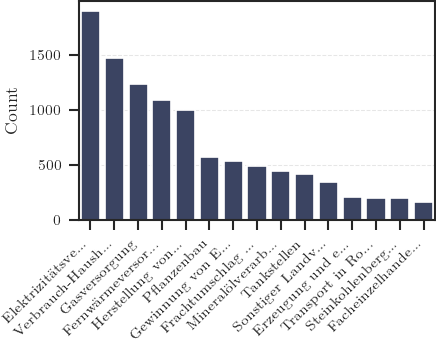

In [67]:
with plot_size(fontsize=8, fraction=0.5):
    ax = sns.barplot(
        data=level_1_labels.value_counts().iloc[:15],  # type: ignore
    )

    ax.set_xlabel("")
    ax.set_ylabel("Count")

    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    save_fig(ax.figure, "probas-classes-count")

Saved to img\probas-output-flows-count.pdf


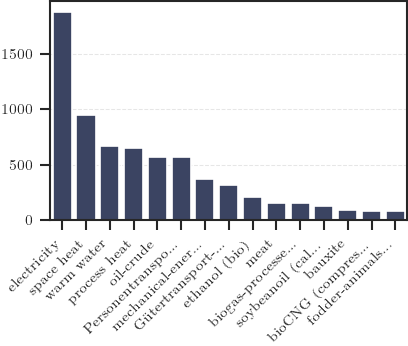

In [68]:
with plot_size(fontsize=8, fraction=0.5):
    ax = sns.barplot(
        process_df["main_flow_name"]
        .apply(shorten_label, max_len=15)
        .value_counts()
        .iloc[:15]  # type: ignore
    )

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    save_fig(ax.figure, "probas-output-flows-count")

In [111]:
display(process_df["input_flows"].describe())
display(process_df["output_flows"].describe())

count    11762.000000
mean        21.566060
std         12.100946
min          1.000000
25%         21.000000
50%         21.000000
75%         21.000000
max        114.000000
Name: input_flows, dtype: float64

count    11762.000000
mean        83.633991
std        203.953048
min         45.000000
25%         60.000000
50%         60.000000
75%         60.000000
max       1702.000000
Name: output_flows, dtype: float64

Saved to img\probas-input-output-flows-scatter.pdf


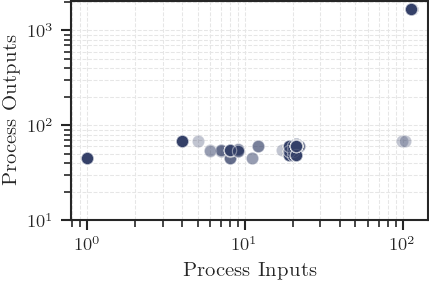

In [69]:
with plot_size(fraction=0.5):
    ax = sns.scatterplot(
        data=process_df,
        x="input_flows",
        y="output_flows",
        alpha=0.3,
        s=35,
    )

    ax.set_xlabel("Process Inputs")
    ax.set_ylabel("Process Outputs")

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_ylim(ymin=10)

    save_fig(ax.figure, "probas-input-output-flows-scatter")

In [99]:
process_df["geography"].value_counts().to_frame().iloc[:15]

,count
geography,
DE,4716
RER,1100
BR,327
RU,253
US,220
AU,208
ID,203
PL,197
CA,196


In [112]:
print(process_df["geography"].value_counts().to_frame().iloc[:15].to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
geography &  \\
\midrule
DE & 4716 \\
RER & 1100 \\
BR & 327 \\
RU & 253 \\
US & 220 \\
AU & 208 \\
ID & 203 \\
PL & 197 \\
CA & 196 \\
GB & 141 \\
NL & 135 \\
ES & 134 \\
FR & 133 \\
UA & 132 \\
AT & 132 \\
\bottomrule
\end{tabular}

